This notebook optimizes ARIMA models for predictiong future export of top five crops for each country.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Customized functions to do ARIMA modeling
import functions.crop_by_country_arima_analyses as ca

In [2]:
# Read in processed data
items_by_country = pd.read_csv('../data/processed/items_by_country.csv',index_col=0)
print(items_by_country.shape)

# Put name for years into a column
# The years list is used by the function below when reshaping data frame 
year = items_by_country.columns[5:-1].tolist() # Select year 1986-2017

(223049, 38)


In [3]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0,0,0,0,0,...,4763,1308,2261,0,0,2714,2086,1778,2756,7
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0,0,0,0,0,...,35476,15894,20270,0,0,16454,12793,10934,19677,7
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0,0,0,0,0,...,0,0,0,0,0,168,181,846,103,4
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0,0,0,0,0,...,0,0,0,0,0,1117,1377,4988,759,4
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0,0,0,0,0,...,11066,779,1016,0,0,1856,1660,1545,875,7


In [7]:
items_by_country.loc[(items_by_country['Reporter Countries']=='India') & (items_by_country['Element']=='Export Quantity'),:].sort_values(by='Y2017', ascending=False)

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
97698,India,Rice - total (Rice milled equivalent),Export Quantity,tonnes,6060,247508,387895,348861,416333,502661,...,2156407,2229270,5018098,10569567,11387090,11161992,11024358,9907031,12120503,32
97710,India,"Rice, milled",Export Quantity,tonnes,6231,247386,386711,348791,416293,502621,...,2131269,2217534,4758844,9329937,10105063,9991903,9662572,9059127,10720892,32
96754,India,"Cake, soybeans",Export Quantity,tonnes,31416,502669,318106,595755,753477,1112140,...,3151855,4202557,5515756,4356543,5193475,2094454,841000,618962,2022420,32
97809,India,Sugar refined,Export Quantity,tonnes,25256,1859,18465,3300,12790,1762,...,17396,915788,1842468,1673320,1340349,1511201,2574442,2910637,1856046,32
97591,India,"Onions, dry",Export Quantity,tonnes,53599,234178,130391,214065,317316,240156,...,1677169,1364342,1110136,1527798,1476573,1267263,1047476,1837251,1621745,32
97702,India,"Rice, broken",Export Quantity,tonnes,3712,122,3,0,40,6,...,844,216,217822,875041,1015579,931256,1146555,729617,1220884,31
96918,India,Cotton lint,Export Quantity,tonnes,95108,200375,71992,2672,23741,332145,...,1328224,1565501,1871158,1918283,2367740,1528377,1250730,866041,938265,32
96910,India,Coir,Export Quantity,tonnes,120324,1,30,20,155,59,...,12839,3189,414,414591,583229,538676,646720,901642,878683,32
97505,India,"Oil, castor beans",Export Quantity,tonnes,38304,5669,4154,1856,32672,39862,...,368432,424319,406244,506310,631034,463703,543746,563665,626819,32
97159,India,"Groundnuts, shelled",Export Quantity,tonnes,34506,25299,4090,20408,29967,46128,...,329161,372692,749039,647956,541338,640640,531111,610575,601849,32


From previous analysis (2_exploratory-analysis-agtrade.ipynb),top five exported crops between 1986 and 2017 in quantities (tonnes) are:   
1) Wheat, 2)Maize, 3)Soybeans, 4)Barley and 5)Rice - total  (Rice milled equivalent)  

We shall build an ARIMA model for each crop of every exporting country, and forecast export into 2025.

### 1. ARIMA modeling for top-five export crops in total quantity between 1986 and 2017

#### 1) Wheat

76 country names selected for those with >50% non-zero data
There were 12 non-stationary countries being removed and
 result in 64 stationary countries


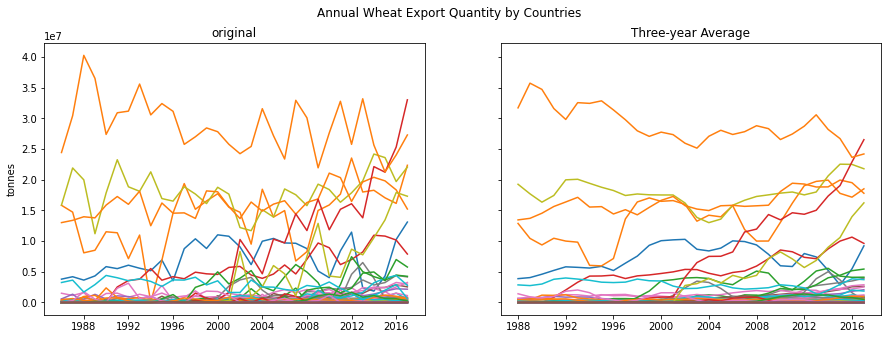

In [9]:
# Assign variables
data = items_by_country.copy()

# For Wheat 
item = 'Wheat'
element = 'Export Quantity' # or Export/Import Value
years = year
unit = 'tonnes' # 1000 US$ for value

# Step 1: preprocessing data
df = ca.crop_country_preprocess(data, years, item, element, plot=True)

df_original = df[0]
df_processed = df[1]

In [43]:

def select_data(df, years, item, element, countries):


    data = df.loc[(df['Item'] == item) & (df['Element'] == element), :]

    # Reshape data from wide to long by years
    data_long = data.melt(['Reporter Countries'], years, 'year', 'value')

    # Convert data to time series
    data_long['year'] = data_long['year'].map(
        lambda x: x.lstrip('Y'))  # strip Y from year names for easy converting to ts
    data_long.year = pd.to_datetime(data_long.year)

    # Reshape data from long to wide, turn countries into columns
    df_original = data_long.pivot(index='year', columns='Reporter Countries', values='value')

    # Calculate 3-year rolling mean
    rolled = df_original.rolling(3).mean().add(1)
    df_normalized = rolled[2:]

    # Filter for countries selected by user
    df_original_selected = df_original[countries]
    df_normalized_selected = df_normalized[countries]
    return df_original_selected,df_normalized_selected



In [64]:
df_original_selected,df_normalized_selected = select_data(items_by_country, years=years, item='Apples', element='Export Quantity', countries=['Albania','Austria'])

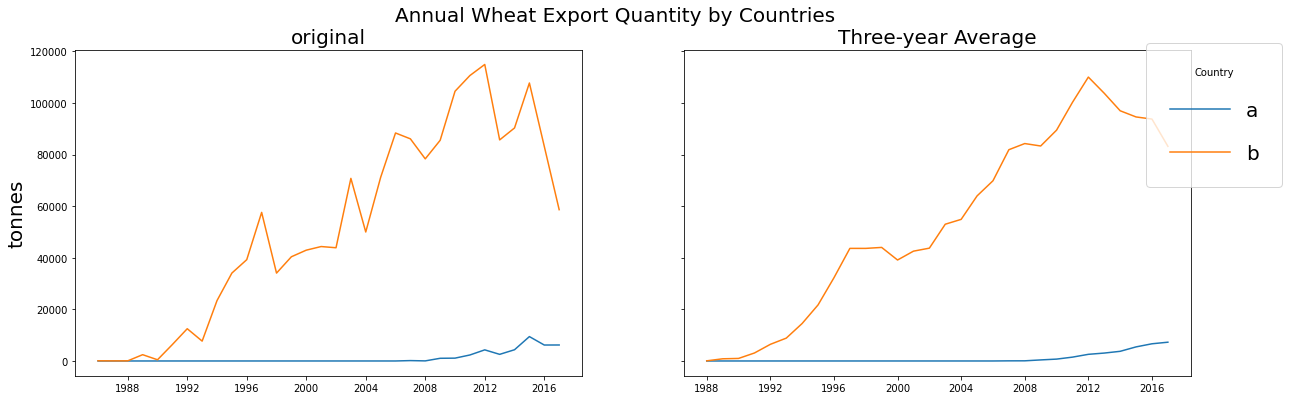

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
ax1.plot(df_original_selected)
ax2.plot(df_normalized_selected)

ax1.set_title('original', fontsize=20)
ax1.set_ylabel('tonnes', fontsize=20)
ax2.set_title('Three-year Average',fontsize=20)
fig.suptitle('Annual {} {} by Countries'.format(item, element), fontsize=20)
# legend
plt.legend(title='Country', labels=['a','b'], loc='upper right', fontsize=20,
          handlelength=3, borderpad=1.2, labelspacing=1.2, bbox_to_anchor=(1.2, 1.05))



In [ ]:
# Step 2: parameter optimazation for ARIMA
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

In [4]:
# If import df_arima results later:
# import ast # for importing best_arima as tuples not strings
# df_arima = pd.read_csv('../data/processed/arima_Wheat_Export Quantity_.csv',
#                        converters={"best_arima": ast.literal_eval},
#                        index_col='country')

In [6]:
# Step 3: use best ARIMA model to forecast
# n_periods = 8 is default
wheat_forecast = ca.crop_country_forecast(df_processed,df_arima)

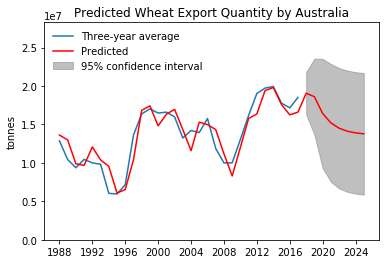

In [9]:
# Unpack results for plotting
forecast_values, lower_ci_values, upper_ci_values = wheat_forecast

# Visualize a few countries
country = 'Australia' # change country name here to see plots
fig = ca.plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)

#### 2). Maize

96 country names selected for those with >50% non-zero data
There were 15 non-stationary countries being removed and
 result in 81 stationary countries


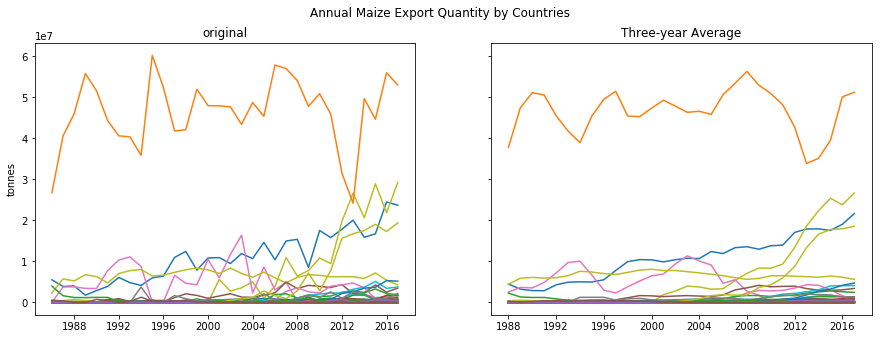

In [13]:
# For Maize 
item = 'Maize'
element = 'Export Quantity' # or Export/Import Value
years = year
unit = 'tonnes' # 1000 US$ for value

# Step 1: preprocessing data
df_original, df_processed= ca.crop_country_preprocess(data, years, item, element, plot=True)

In [71]:
# Step 2: parameter optimazation for ARIMA
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

In [72]:
# Step 3: use best ARIMA model to forecast

maize_forecast = ca.crop_country_forecast(df_processed,df_arima)

# Unpack results for plotting
forecast_values, lower_ci_values, upper_ci_values = maize_forecast

# Visualize a few countries
country = Australia'
fig = ca.plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)

#### 3) Soybeans

63 country names selected for those with >50% non-zero data
There were 9 non-stationary countries being removed and
 result in 54 stationary countries


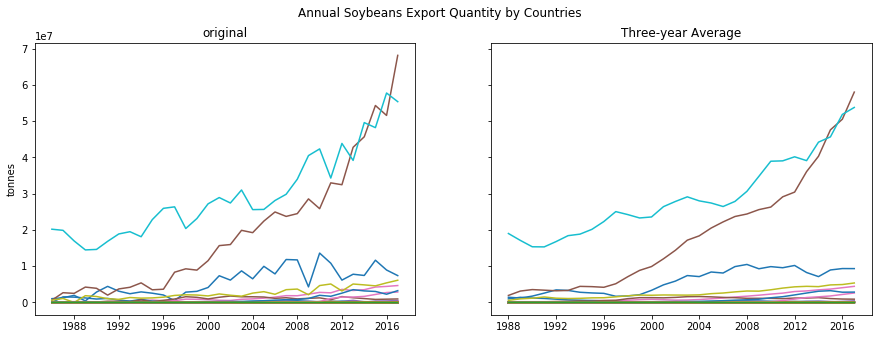

In [42]:
# For Soybeans 
item = 'Soybeans'
element = 'Export Quantity' # or Export/Import Value
years = year
unit = 'tonnes' # 1000 US$ for value

# Step 1: preprocessing data
df_original, df_processed= ca.crop_country_preprocess(data, years, item, element, plot=True)

In [73]:
# Step 2: parameter optimazation for ARIMA
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

In [ ]:
# Step 3: use best ARIMA model to forecast

# import ast # for importing best_arima as tuples not strings
# df_arima = pd.read_csv('../data/processed/arima_Soybeans_Export Quantity_.csv',
#                        converters={"best_arima": ast.literal_eval},
#                        index_col='country')

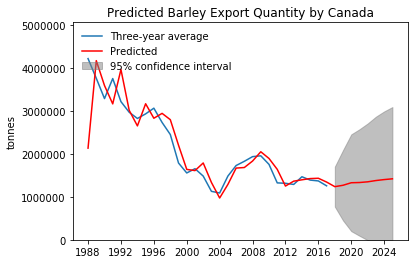

In [50]:
soybean_forecast = ca.crop_country_forecast(df_processed,df_arima)

# Unpack results for plotting
forecast_values, lower_ci_values, upper_ci_values = soybean_forecast

# Visualize a few countries
country = 'Canada'
fig = ca.plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)

4) Barley

58 country names selected for those with >50% non-zero data
There were 10 non-stationary countries being removed and
 result in 48 stationary countries


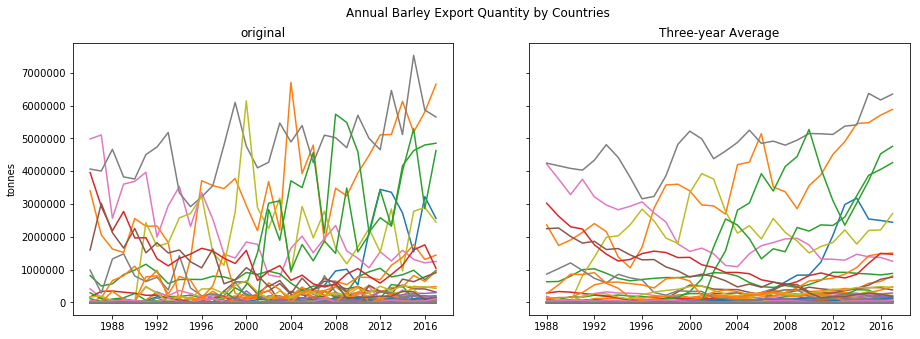

In [48]:
# For Barley
item = 'Barley'
element = 'Export Quantity' # or Export/Import Value
years = year
unit = 'tonnes' # 1000 US$ for value

# Step 1: preprocessing data
df_original, df_processed= ca.crop_country_preprocess(data, years, item, element, plot=True)

In [74]:
# Step 2: parameter optimazation for ARIMA
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

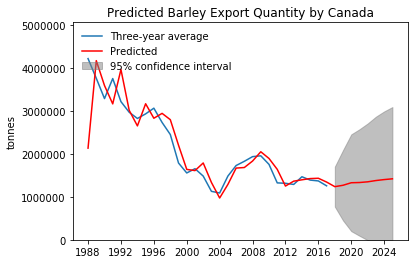

In [51]:
barley_forecast = ca.crop_country_forecast(df_processed,df_arima)

# Unpack results for plotting
forecast_values, lower_ci_values, upper_ci_values = barley_forecast

# Visualize a few countries
country = 'Canada'
fig = ca.plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)

5) Rice

102 country names selected for those with >50% non-zero data
There were 19 non-stationary countries being removed and
 result in 83 stationary countries


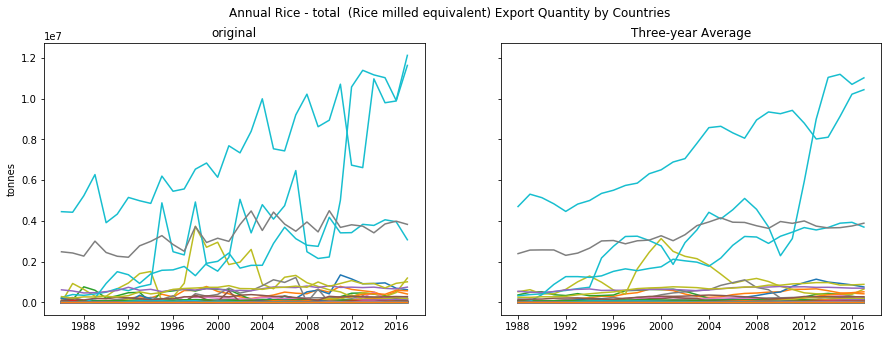

In [74]:
# For Rice
item = 'Rice - total  (Rice milled equivalent)'
element = 'Export Quantity' # or Export/Import Value
years = year
unit = 'tonnes' # 1000 US$ for value

# Step 1: preprocessing data
df_original, df_processed= ca.crop_country_preprocess(data, years, item, element, plot=True)
# Rice - total (Rice milled equivalent)

In [75]:
# Step 2: parameter optimazation for ARIMA
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

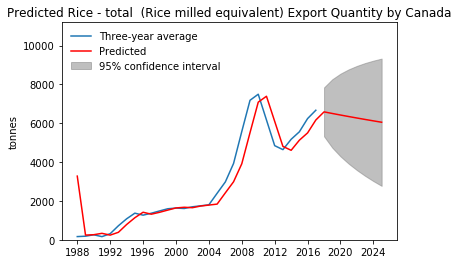

In [76]:
rice_forecast = ca.crop_country_forecast(df_processed,df_arima)

# Unpack results for plotting
forecast_values, lower_ci_values, upper_ci_values = rice_forecast

# Visualize a few countries
country = 'Canada'
fig = ca.plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)

**Summary**   
ARIMA model performed fairly well. However, with customized functions there are still too many repetitive codes.   Next: wrap steps into fewer functions for easy implementation. Create dashboard and host through AWS.